# **High dimensional texture mixing**

How to use this notebook? 

1. Implementation of the last part of the paper on "high dimensional texture mixing. 
2. Examples where this technique fails 
3. Comparison of all techniques seen so far (first order, high dimensional and our regularization method).

In [1]:
#use this cell to be at the root of the project (if needed)
import os
print(os.getcwd())
os.chdir('../')
print(os.getcwd())

/Users/marionchabrol/Documents/MVA/wasserstein/experiments
/Users/marionchabrol/Documents/MVA/wasserstein


In [2]:
from utils.image_treatment import preprocess_image
from wasserstein.texture_mixing_new import compute_texture_mixing, compute_optimal_transport_barycenter, build_pyramid, compute_optimal_assignment, compute_optimal_transport, build_pyramid_barycenters, pyramid_projection
import matplotlib.pyplot as plt
import numpy as np
import pyrtools as pt
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from skimage.util import view_as_blocks
from tqdm import tqdm

## **High dimensional texture mixing as in the paper**

### **Define utils functions**

In [2]:
### Define functions to use blocks as in the last part of the paper

def build_blocks(pyramid, block_shape = (4, 4, 3)):
    blocks = {}
    for key in pyramid.keys():
        # divide the image into blocks
        blocks[key] = view_as_blocks(pyramid[key], block_shape=block_shape)
    return(blocks)

def block_projection(block_wn, block_barycenter):
    """
    Compute the projections of white noise pyramid coefficients on barycenter pyramid coefficients (see 13 in paper)

    Parameters:
    - pyramid_wn (dict): white noise pyramid coefficients
    - pyramid_barycenter (dict): barycenter pyramid coefficients

    Returns:
    - pyramid_wn (dict): projection of white noise pyramid coefficients on barycenter pyramid
    """
    for key in block_wn.keys():
        size = block_wn[key].shape[0]
        projection = compute_optimal_assignment(block_wn[key].reshape(-1, 4*4*3), block_barycenter[key].reshape(-1, 4*4*3)).reshape(size, size, 4, 4, 3)
        block_wn[key] = projection
    
    return(block_wn)


def texture_mixing_high_dim(textures, rho, n_neighbor = 4, num_scales = 4, num_orientations = 4):
    size = textures[0].shape[0]
    noise = np.random.randn(size, size, 3)

    # compute  Y
    Y = compute_optimal_transport_barycenter(noise.reshape(-1, 3), rho, [x.reshape(-1, 3) for x in textures], iterations=100).reshape(size, size, 3)

    # compute Y_l_j 
    pyramids = []
    for texture in textures:
        pyramids.append(build_pyramid(texture, num_scales=num_scales, num_orientations=num_orientations)) #returns a dico with pyramid for R,G,B
    
    # compute pyramid coefficients for white noise
    pyramid_wn = build_pyramid(noise, num_scales=num_scales, num_orientations=num_orientations)

    blocks = [build_blocks(x) for x in pyramids]
    block_wn = build_blocks(pyramid_wn)

    block_barycenter = {}
    for key in tqdm(block_wn.keys()):
        size = block_wn[key].shape[0]
        block_barycenter[key] = compute_optimal_transport_barycenter(block_wn[key].reshape(-1,n_neighbor*n_neighbor*3), rho, [x[key].reshape(-1,n_neighbor*n_neighbor*3) for x in blocks])
        block_barycenter[key] = block_barycenter[key].reshape(size, size, 1, n_neighbor, n_neighbor, 3)

    pyramid_barycenter = build_pyramid_barycenters(pyramid_wn, pyramids, rho, num_scales = num_scales, num_orientations = num_orientations)
    
    #(13), see article
    pyramid_wn = build_pyramid(noise, num_scales=num_scales, num_orientations=num_orientations)
    c_lm = pyramid_projection(pyramid_wn, pyramid_barycenter)

    block_c_lm = build_blocks(c_lm)

    new_coeffs = block_projection(block_c_lm, block_barycenter)
    for key in new_coeffs.keys():
        size = new_coeffs[key].shape[0]
        new_coeffs[key] = new_coeffs[key].reshape(size*n_neighbor,size*n_neighbor,3)

    pyramid_barycenter_r = {}
    pyramid_barycenter_g = {}
    pyramid_barycenter_b = {}
    for key in pyramid_barycenter.keys(): # for every coeff in RGB
        # extract coeff for R G B 
        pyramid_barycenter_r[key] = new_coeffs[key][:,:,0]
        pyramid_barycenter_g[key] = new_coeffs[key][:,:,1]
        pyramid_barycenter_b[key] = new_coeffs[key][:,:,2]

    # reconstruct images with each pyramid R G B 
    size = 256
    noise_for_pyr = np.random.randn(size, size)
    noisy_pyr = pt.pyramids.SteerablePyramidFreq(noise_for_pyr, height=4, order=4-1)

    noisy_pyr.pyr_coeffs = pyramid_barycenter_r
    reconstructed_pyr_r = noisy_pyr.recon_pyr()
    noisy_pyr.pyr_coeffs = pyramid_barycenter_g
    reconstructed_pyr_g = noisy_pyr.recon_pyr()
    noisy_pyr.pyr_coeffs = pyramid_barycenter_b
    reconstructed_pyr_b = noisy_pyr.recon_pyr()

    # f_tilde(k)
    reconstructed_pyr = np.stack((reconstructed_pyr_r, reconstructed_pyr_g, reconstructed_pyr_b), axis = -1)

    # f_k+1
    final_texture = compute_optimal_transport(reconstructed_pyr.reshape(-1,3), Y.reshape(-1, 3),iterations=50).reshape(size, size, 3)
    noise = final_texture

    return(final_texture.astype(int))

## **Example 1 where it does not work**

In [3]:
### Example where it does not work 

image_path3 = 'data/161.gif'
image_path4 = 'data/Wall.jpg'
image3 = preprocess_image(image_path3, new_size = (256,256))
image4 = preprocess_image(image_path4, new_size = (256,256))
rho = [0.9, 0.1]
textures = [image3, image4]


In [4]:
synthesis_without_patch = compute_texture_mixing(textures, rho)
synthesis_with_patch = texture_mixing_high_dim(textures, rho, n_neighbor = 4, num_scales = 4, num_orientations = 4)

100%|██████████| 18/18 [00:07<00:00,  2.33it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6..264].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-13..259].


Text(0.5, 1.0, 'taking joint distribution')

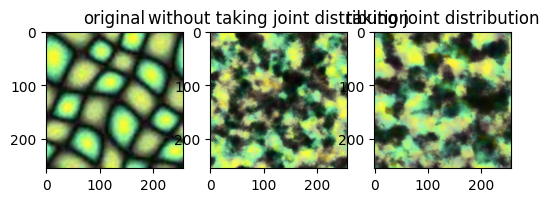

In [5]:
plt.figure(figsize=(6, 3))
plt.subplot(1,3,1)
plt.imshow(image3)
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(synthesis_without_patch)
plt.title('without taking joint distribution')
plt.subplot(1,3,3)
plt.imshow(synthesis_with_patch)
plt.title('taking joint distribution')


## **Example 2 where it does not work**

In [6]:
#exemple où ça marche moins bien
image_path3 = 'data/Red.jpg'
image_path4 = 'data/Wall.jpg'
image3 = preprocess_image(image_path3, new_size = (256,256))
image4 = preprocess_image(image_path4, new_size = (256,256))

textures = [image3, image4]
rho = [0.2, 0.5, 0.8]
final_texture_without_constraints = []
for r in rho:
    final_texture_without_constraints.append(texture_mixing_high_dim(textures, [1-r, r], num_scales = 4, num_orientations = 4))

100%|██████████| 18/18 [00:08<00:00,  2.12it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3..231].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1..243].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3..253].


Text(0.5, 1.0, 'Original $f^2$')

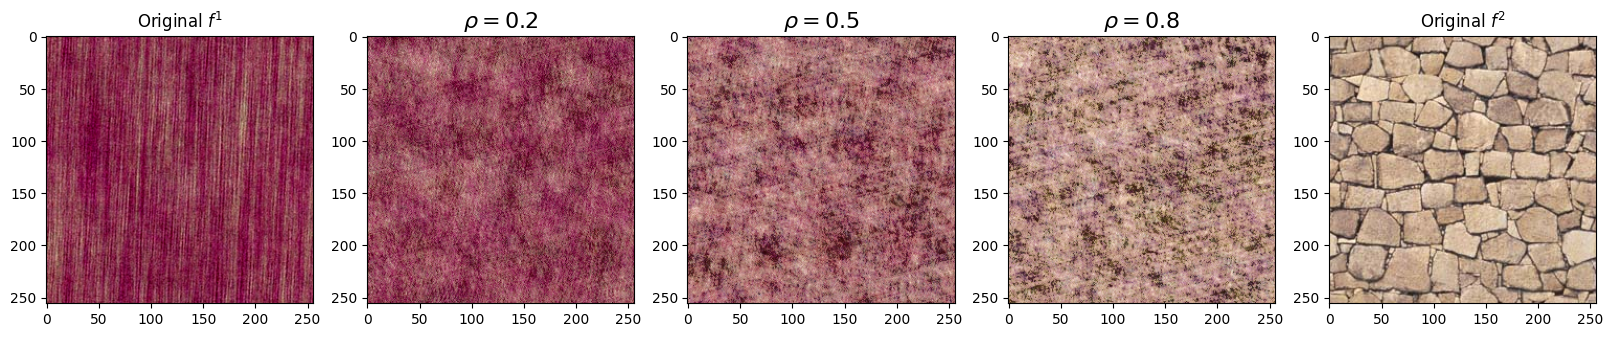

In [7]:
plt.figure(figsize=(20, 10))
plt.subplot(1,5,1)
plt.imshow(image3)
plt.title('Original $f^1$')
for i in range(len(final_texture_without_constraints)):
    plt.subplot(1,5,i+2)
    plt.imshow(final_texture_without_constraints[i].astype(int))
    plt.title(f'$\\rho = {rho[i]}$', fontsize=16)
plt.subplot(1,5,5)
plt.imshow(image4)
plt.title('Original $f^2$')

## **Brickwall**

In [8]:
image_path = 'data/Bricks.jpg'
image = preprocess_image(image_path, new_size = (256,256))

textures = [image]
synthesis_with_patch = texture_mixing_high_dim(textures, rho=[1], n_neighbor = 4, num_scales = 4, num_orientations = 4)

100%|██████████| 18/18 [00:05<00:00,  3.55it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2..254].


Text(0.5, 1.0, 'Synthesis high dim')

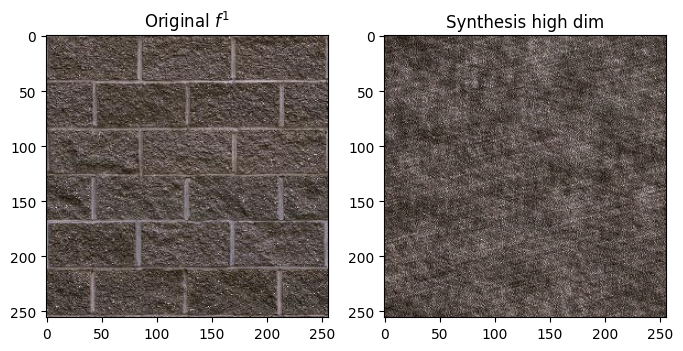

In [9]:
plt.figure(figsize=(8, 10))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title('Original $f^1$')
plt.subplot(1,2,2)
plt.imshow(synthesis_with_patch)
plt.title('Synthesis high dim')

# **Final plots: Comparison between techniques**

### **Define utils functions for comparison**

In [10]:
### Define utils functions

def compute_optimal_transport_barycenter_with_regularization(
    X_ini, lambdas, point_clouds, iterations=10, projections=10, regularization_weight=0.5, return_asg=False
):
    """
    Compute the optimal transport barycenter of multiple point clouds with spatial regularization.

    Parameters:
    - X_ini (ndarray): Initial point cloud for the barycenter computation
    - lambdas (list): List of weights corresponding to the contribution of each point cloud
    - point_clouds (list): List of point clouds (ndarrays) to be averaged
    - iterations (int): Number of iterations for the optimization process
    - projections (int): Number of random projections used in each iteration
    - regularization_weight (float): Weight for the spatial regularization term
    - return_asg (bool): If True, return the sorted indices of the final point cloud

    Returns:
    - ndarray: Optimal transport barycenter of the input point clouds
    - (Optional) ndarray: Sorted indices of the final point cloud along with the input point clouds
    """
    
    assert 1 - 1e-5 < sum(lambdas) < 1 + 1e-5, 'the sum of the weights must be 1'
    Z = X_ini.copy()
    N = X_ini.shape[0]
    D = X_ini.shape[-1]
    size = np.sqrt(N)
    lr = 1
    if projections == -1:
        projections = D
    
    for i in range(iterations):
        grad = np.zeros((N, D))
        for p in range(projections):
            theta = np.random.uniform(-1, 1, D)
            theta /= np.linalg.norm(theta)
            for lmb in range(len(lambdas)):
                grad_tmp = 0
                proj_z = Z @ theta
                proj_y = point_clouds[lmb] @ theta
                sz = np.argsort(proj_z)
                sy = np.argsort(proj_y)
                grad_tmp += lambdas[lmb] * (proj_z[sz] - proj_y[sy])
                grad_tmp = grad_tmp.reshape(-1, 1)
                grad += grad_tmp @ theta.reshape(-1, 1).T
        
        # Regularization term
        reg_grad = np.zeros_like(Z)
        for l in range(N):
            #neighbors = [k for k in range(max(0, j - 1), min(N, j + 2)) if k != j]

            #########################################
            neighbors_indices = []
            i, j = divmod(l, size)
        
            #Collect all potential neighbors' 2D coordinates
            # neighbor_coords = [
                           
            #     (i-1,j-1), (i-1, j), (i-1,j+1),  # Top row
            #     (i, j-1),            (i, j+1),     # Middle row
            #     (i+1,j-1),    (i+1, j), (i+1,j+1)
            #                     # Bottom row
            # ]

            neighbor_coords = [
                (i-2,j-1),  (i-2,j), (i-2,j+1),
                (i-1,j-1), (i-1, j), (i-1,j+1),  # Top row
                (i, j-2), (i, j-1),            (i, j+1), (i, j+2),    # Middle row
                (i+1,j-1),    (i+1, j), (i+1,j+1),
                (i+2,j-1), (i+2,j), (i+2, j+1)
                                # Bottom row
            ]

            
            # Filter valid coordinates (inside the matrix bounds)
            valid_coords = [
                (x, y) for x, y in neighbor_coords if ((0 <= x < size) and (0 <= y < size))
            ]
            
            # Convert valid coordinates back to flat indices
            flat_indices = [int(x * size + y) for x, y in valid_coords]
            neighbors_indices.append(flat_indices)
            ##############################################
            for k in neighbors_indices[0]:
                reg_grad[l] += 2 * (Z[l] - Z[k])

            
        grad += regularization_weight * reg_grad

        # Update Z
        Z -= lr * grad / projections
        lr *= 0.999

    if return_asg:
        return Z, sy, sz
    return Z


def build_pyramid_barycenters_with_reg(pyramid_wn, pyramids, rho, num_scales=4, num_orientations=4):
    """
    Computes the optimal transport barycenter of each coefficient (in color/RGB) of the pyramid
    (builds the pyramid and then computes barycenter).

    Parameters:
    - pyramid_wn (dict): Pyramid coefficients of a white noise
    - pyramids (list of dict): List of pyramids, each containing coefficients for different textures
    - rho (list): List of weights corresponding to the contribution of each texture
    - num_scales (int): Number of scales (for pyramid decomposition)
    - num_orientations (int): Number of orientations (for pyramid decomposition)

    Returns:
    - dict: Optimal transport barycenter of each coefficient of the pyramid
    """
    
    def compute_barycenter_for_key(key):
        size = pyramid_wn[key].shape[0]
        barycenter = compute_optimal_transport_barycenter_with_regularization(
            pyramid_wn[key].reshape(-1, 3), rho, [x[key].reshape(-1, 3) for x in pyramids]
        )
        return key, barycenter.reshape(size, size, 3)

    # Use Joblib's Parallel to compute each key in parallel
    results = Parallel(n_jobs=-1)(
        delayed(compute_barycenter_for_key)(key) for key in tqdm(pyramid_wn.keys())
    )

    # Aggregate results into the pyramid_barycenter dictionary
    pyramid_barycenter = {key: barycenter for key, barycenter in results}
    
    return pyramid_barycenter

def compute_texture_mixing_with_reg(textures, rho, num_scales = 4, num_orientations = 4, n_iter = 1):
    """
    Computes the optimal transport textures barycenter 

    Parameters:
    - textures (list): List of textures for which we are computing the barycenter
    - rho (List): list of weights corresponding to the contribution of each texture
    - num_scales (int): number of scales (for pyramid decomposition)
    - num_orientations (int): number of orientations (for pyramid decomposition)

    Returns:
    - final_texture (ndarray): textures barycenter
    """

    #Initialization of a noise
    size = textures[0].shape[0]
    noise = np.random.randn(size, size, 3)

    #Compute Y
    Y = compute_optimal_transport_barycenter(noise.reshape(-1, 3), rho, [x.reshape(-1, 3) for x in textures], iterations=100).reshape(size, size, 3)
    #Compute Y_l,j (compute pyramid coefficients for each texture)
    pyramids = []
    for texture in textures:
        pyramids.append(build_pyramid(texture, num_scales=num_scales, num_orientations=num_orientations)) #returns a dico with pyramid for R,G,B
    #compute pyramid coefficients for white noise
    pyramid_wn = build_pyramid(noise, num_scales=num_scales, num_orientations=num_orientations)

    #Compute Y_l (= pyramid_barycenter)
    pyramid_barycenter = build_pyramid_barycenters_with_reg(pyramid_wn, pyramids, rho, num_scales = num_scales, num_orientations = num_orientations)
    
    
    #(13), see article
    for _ in range(n_iter):
        pyramid_wn = build_pyramid(noise, num_scales=4, num_orientations=4)
        pyramid_wn = pyramid_projection(pyramid_wn, pyramid_barycenter)

        pyramid_barycenter_r = {}
        pyramid_barycenter_g = {}
        pyramid_barycenter_b = {}
        for key in pyramid_barycenter.keys(): 
            pyramid_barycenter_r[key] = pyramid_wn[key][:,:,0]
            pyramid_barycenter_g[key] = pyramid_wn[key][:,:,1]
            pyramid_barycenter_b[key] = pyramid_wn[key][:,:,2]

        noise_for_pyr = np.random.randn(size, size)
        noisy_pyr = pt.pyramids.SteerablePyramidFreq(noise_for_pyr, height=num_scales, order=num_orientations-1)

        noisy_pyr.pyr_coeffs = pyramid_barycenter_r
        reconstructed_pyr_r = noisy_pyr.recon_pyr()
        noisy_pyr.pyr_coeffs = pyramid_barycenter_g
        reconstructed_pyr_g = noisy_pyr.recon_pyr()
        noisy_pyr.pyr_coeffs = pyramid_barycenter_b
        reconstructed_pyr_b = noisy_pyr.recon_pyr()

        #f_tilde(k)
        reconstructed_pyr = np.stack((reconstructed_pyr_r, reconstructed_pyr_g, reconstructed_pyr_b), axis = -1)

        #f_k+1
        final_texture = compute_optimal_transport(reconstructed_pyr.reshape(-1,3), Y.reshape(-1, 3),iterations=50).reshape(size, size, 3)
        noise = final_texture
    
    return(final_texture.astype(int))


In [11]:
image_path = 'data/brick_article.png'
size = 256
image = preprocess_image(image_path, new_size = (size,size))

textures = [image]

In [12]:
synthesis_with_patch = texture_mixing_high_dim(textures, rho=[1], n_neighbor = 4, num_scales = 4, num_orientations = 4)
synthesis = compute_texture_mixing(textures, rho=[1], num_scales = 4, num_orientations = 4)

100%|██████████| 18/18 [00:05<00:00,  3.30it/s]


In [13]:
synthesis_with_reg =compute_texture_mixing_with_reg(textures, rho=[1], num_scales = 4, num_orientations = 4, n_iter = 10)

100%|██████████| 18/18 [00:33<00:00,  1.88s/it]


Text(0.5, 1.0, 'Synthesis with Regularization')

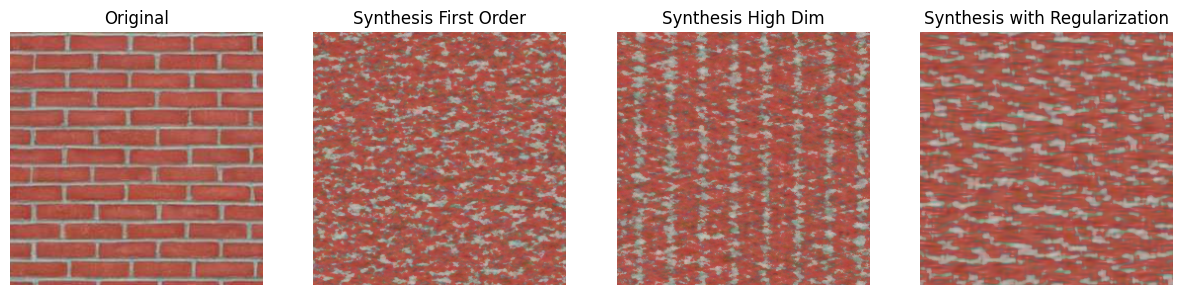

In [14]:
plt.figure(figsize=(15, 10))
plt.subplot(1,4,1)
plt.imshow(image)
plt.axis("off")
plt.title('Original')
plt.subplot(1,4,2)
plt.imshow(synthesis)
plt.axis("off")
plt.title('Synthesis First Order')
plt.subplot(1,4,3)
plt.imshow(synthesis_with_patch)
plt.axis("off")
plt.title('Synthesis High Dim')
plt.subplot(1,4,4)
plt.imshow(synthesis_with_reg)
plt.axis("off")
plt.title('Synthesis with Regularization')

## **Choose the best among several candidates**

In [15]:
image_path = 'data/brick_article.png'
size = 256
image = preprocess_image(image_path, new_size = (size,size))

textures = [image]

In [16]:
synthesis_with_patch = texture_mixing_high_dim(textures, rho=[1], n_neighbor = 4, num_scales = 4, num_orientations = 4)
synthesis = compute_texture_mixing(textures, rho=[1], num_scales = 4, num_orientations = 4)

100%|██████████| 18/18 [00:07<00:00,  2.44it/s]


100%|██████████| 18/18 [00:46<00:00,  2.59s/it]


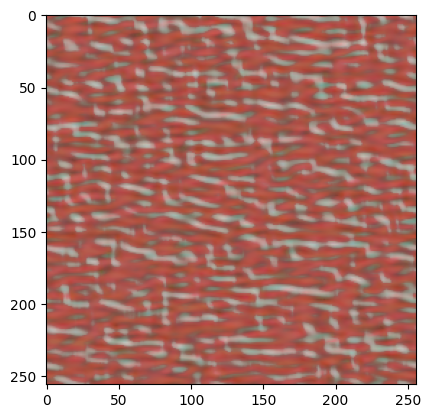

In [17]:
synthesis_with_reg_1 =compute_texture_mixing_with_reg(textures, rho=[1], num_scales = 4, num_orientations = 4, n_iter = 10)
plt.imshow(synthesis_with_reg_1)

100%|██████████| 18/18 [00:43<00:00,  2.44s/it]


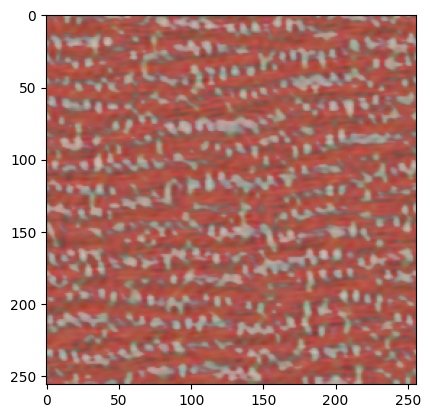

In [18]:
synthesis_with_reg_2 =compute_texture_mixing_with_reg(textures, rho=[1], num_scales = 4, num_orientations = 4, n_iter = 10)
plt.imshow(synthesis_with_reg_2)

100%|██████████| 18/18 [00:50<00:00,  2.78s/it]


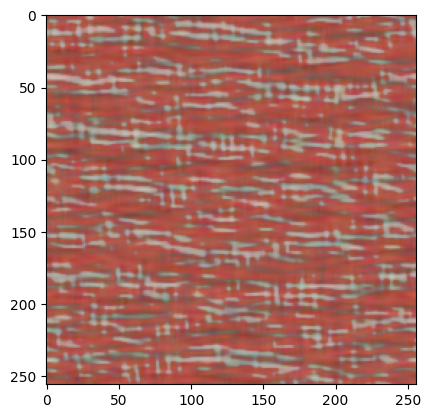

In [19]:
synthesis_with_reg_3 =compute_texture_mixing_with_reg(textures, rho=[1], num_scales = 4, num_orientations = 4, n_iter = 10)
plt.imshow(synthesis_with_reg_3)

100%|██████████| 18/18 [21:23<00:00, 71.32s/it]


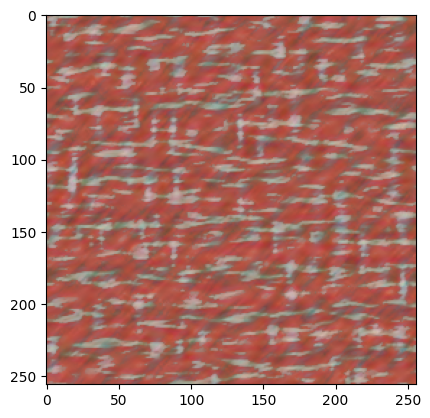

In [20]:
synthesis_with_reg_4 =compute_texture_mixing_with_reg(textures, rho=[1], num_scales = 4, num_orientations = 4, n_iter = 10)
plt.imshow(synthesis_with_reg_4)

100%|██████████| 18/18 [00:24<00:00,  1.38s/it]


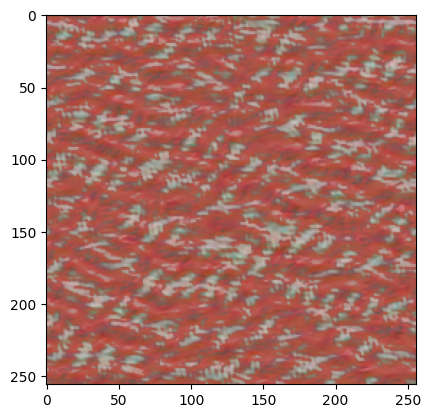

In [21]:
synthesis_with_reg_5 =compute_texture_mixing_with_reg(textures, rho=[1], num_scales = 4, num_orientations = 4, n_iter = 10)
plt.imshow(synthesis_with_reg_5)

Text(0.5, 1.0, 'Synthesis with Regularization')

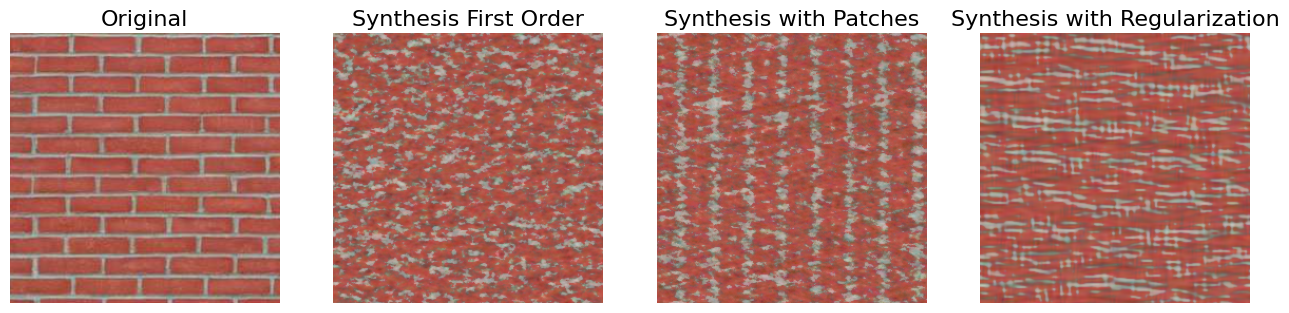

In [22]:
plt.figure(figsize=(16, 12))
plt.subplot(1,4,1)
plt.imshow(image)
plt.axis("off")
plt.title('Original', fontsize=16)
plt.subplot(1,4,2)
plt.imshow(synthesis)
plt.axis("off")
plt.title('Synthesis First Order', fontsize=16)
plt.subplot(1,4,3)
plt.imshow(synthesis_with_patch)
plt.axis("off")
plt.title('Synthesis with Patches', fontsize=16)
plt.subplot(1,4,4)
plt.imshow(synthesis_with_reg_3)
plt.axis("off")
plt.title('Synthesis with Regularization', fontsize=16)

Text(0.5, 1.0, 'Synthesis with Regularization')

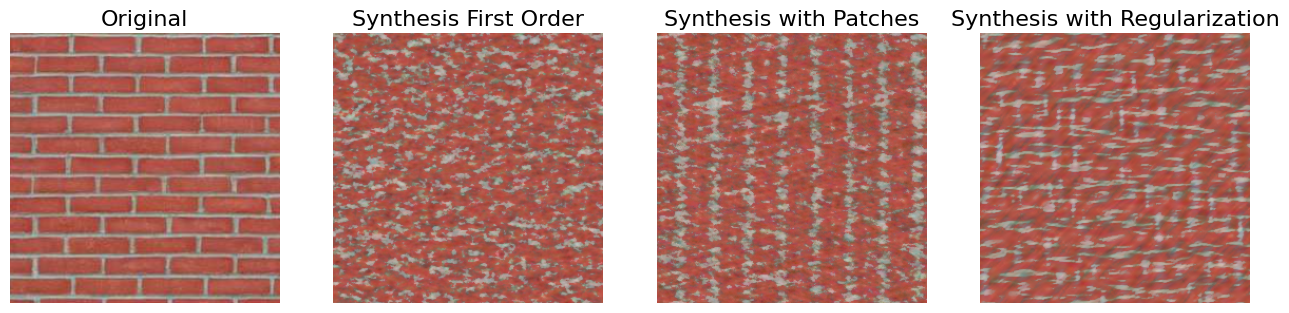

In [23]:
plt.figure(figsize=(16, 12))
plt.subplot(1,4,1)
plt.imshow(image)
plt.axis("off")
plt.title('Original', fontsize=16)
plt.subplot(1,4,2)
plt.imshow(synthesis)
plt.axis("off")
plt.title('Synthesis First Order', fontsize=16)
plt.subplot(1,4,3)
plt.imshow(synthesis_with_patch)
plt.axis("off")
plt.title('Synthesis with Patches', fontsize=16)
plt.subplot(1,4,4)
plt.imshow(synthesis_with_reg_4)
plt.axis("off")
plt.title('Synthesis with Regularization', fontsize=16)